# Flir Tau2 Pre-Processing

## Packages and data imports:

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().cwd().parent))

from tools import get_measurements, prefilt_cam_meas, FilterWavelength, FilterWavelength
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plots import showFacetImages
import pandas as pd
import seaborn as sns
%load_ext autoreload
%autoreload 2

matplotlib.rcParams.update({'font.size': 14})

path_to_files = Path.cwd()
while not (path_to_files / "rawData").is_dir():
    path_to_files = path_to_files.parent
path_to_files = path_to_files / "rawData" / 'calib' / 'tlinear_0'

meas_panchromatic, fpa, housing, list_power_panchromatic, list_blackbody_temperatures, _ =\
    get_measurements(
        path_to_files, filter_wavelength=FilterWavelength.PAN, fast_load=True)


calculating power: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


## Raw Data Visualization:
Before diving into processing the input images, it's a good idea to have a look at the raw data in order to get a better idea of its quality and evident issues.


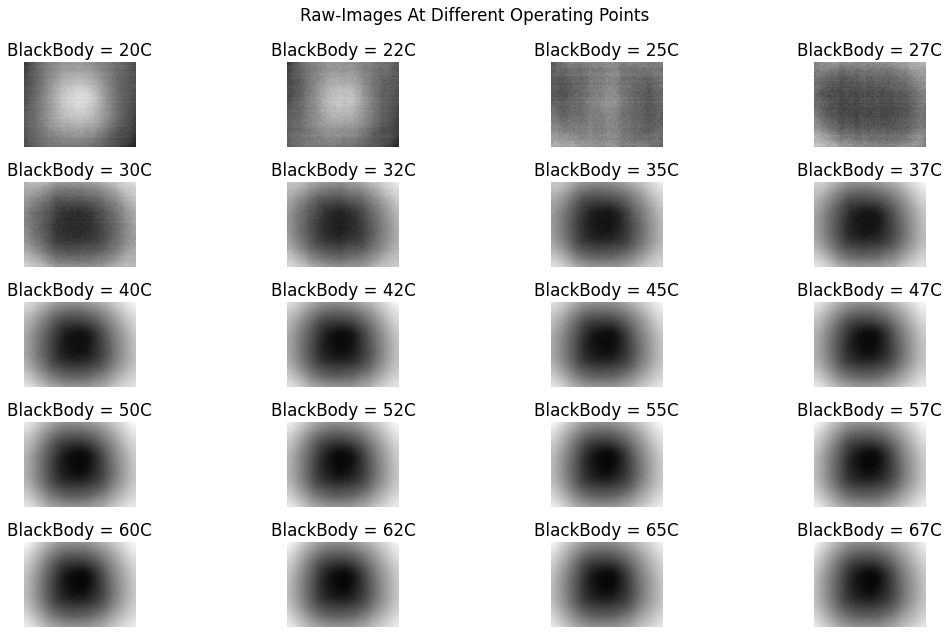

In [2]:
# Display the Average Frames of the different operating points:
ROW_LENGTH = 4
meas_panchromatic_mean = meas_panchromatic.mean(axis=1)
fig, axs = plt.subplots(max(1, meas_panchromatic_mean.shape[0] // ROW_LENGTH), ROW_LENGTH, figsize=(16, 9))
for ax, image, t_bb in zip(axs.ravel(), meas_panchromatic_mean, list_blackbody_temperatures):
    ax.imshow(image, cmap="gray")
    ax.set_title(f"BlackBody = {t_bb}C")
    ax.axis("off")
fig.suptitle("Raw-Images At Different Operating Points")
plt.tight_layout()
plt.show()
plt.close()


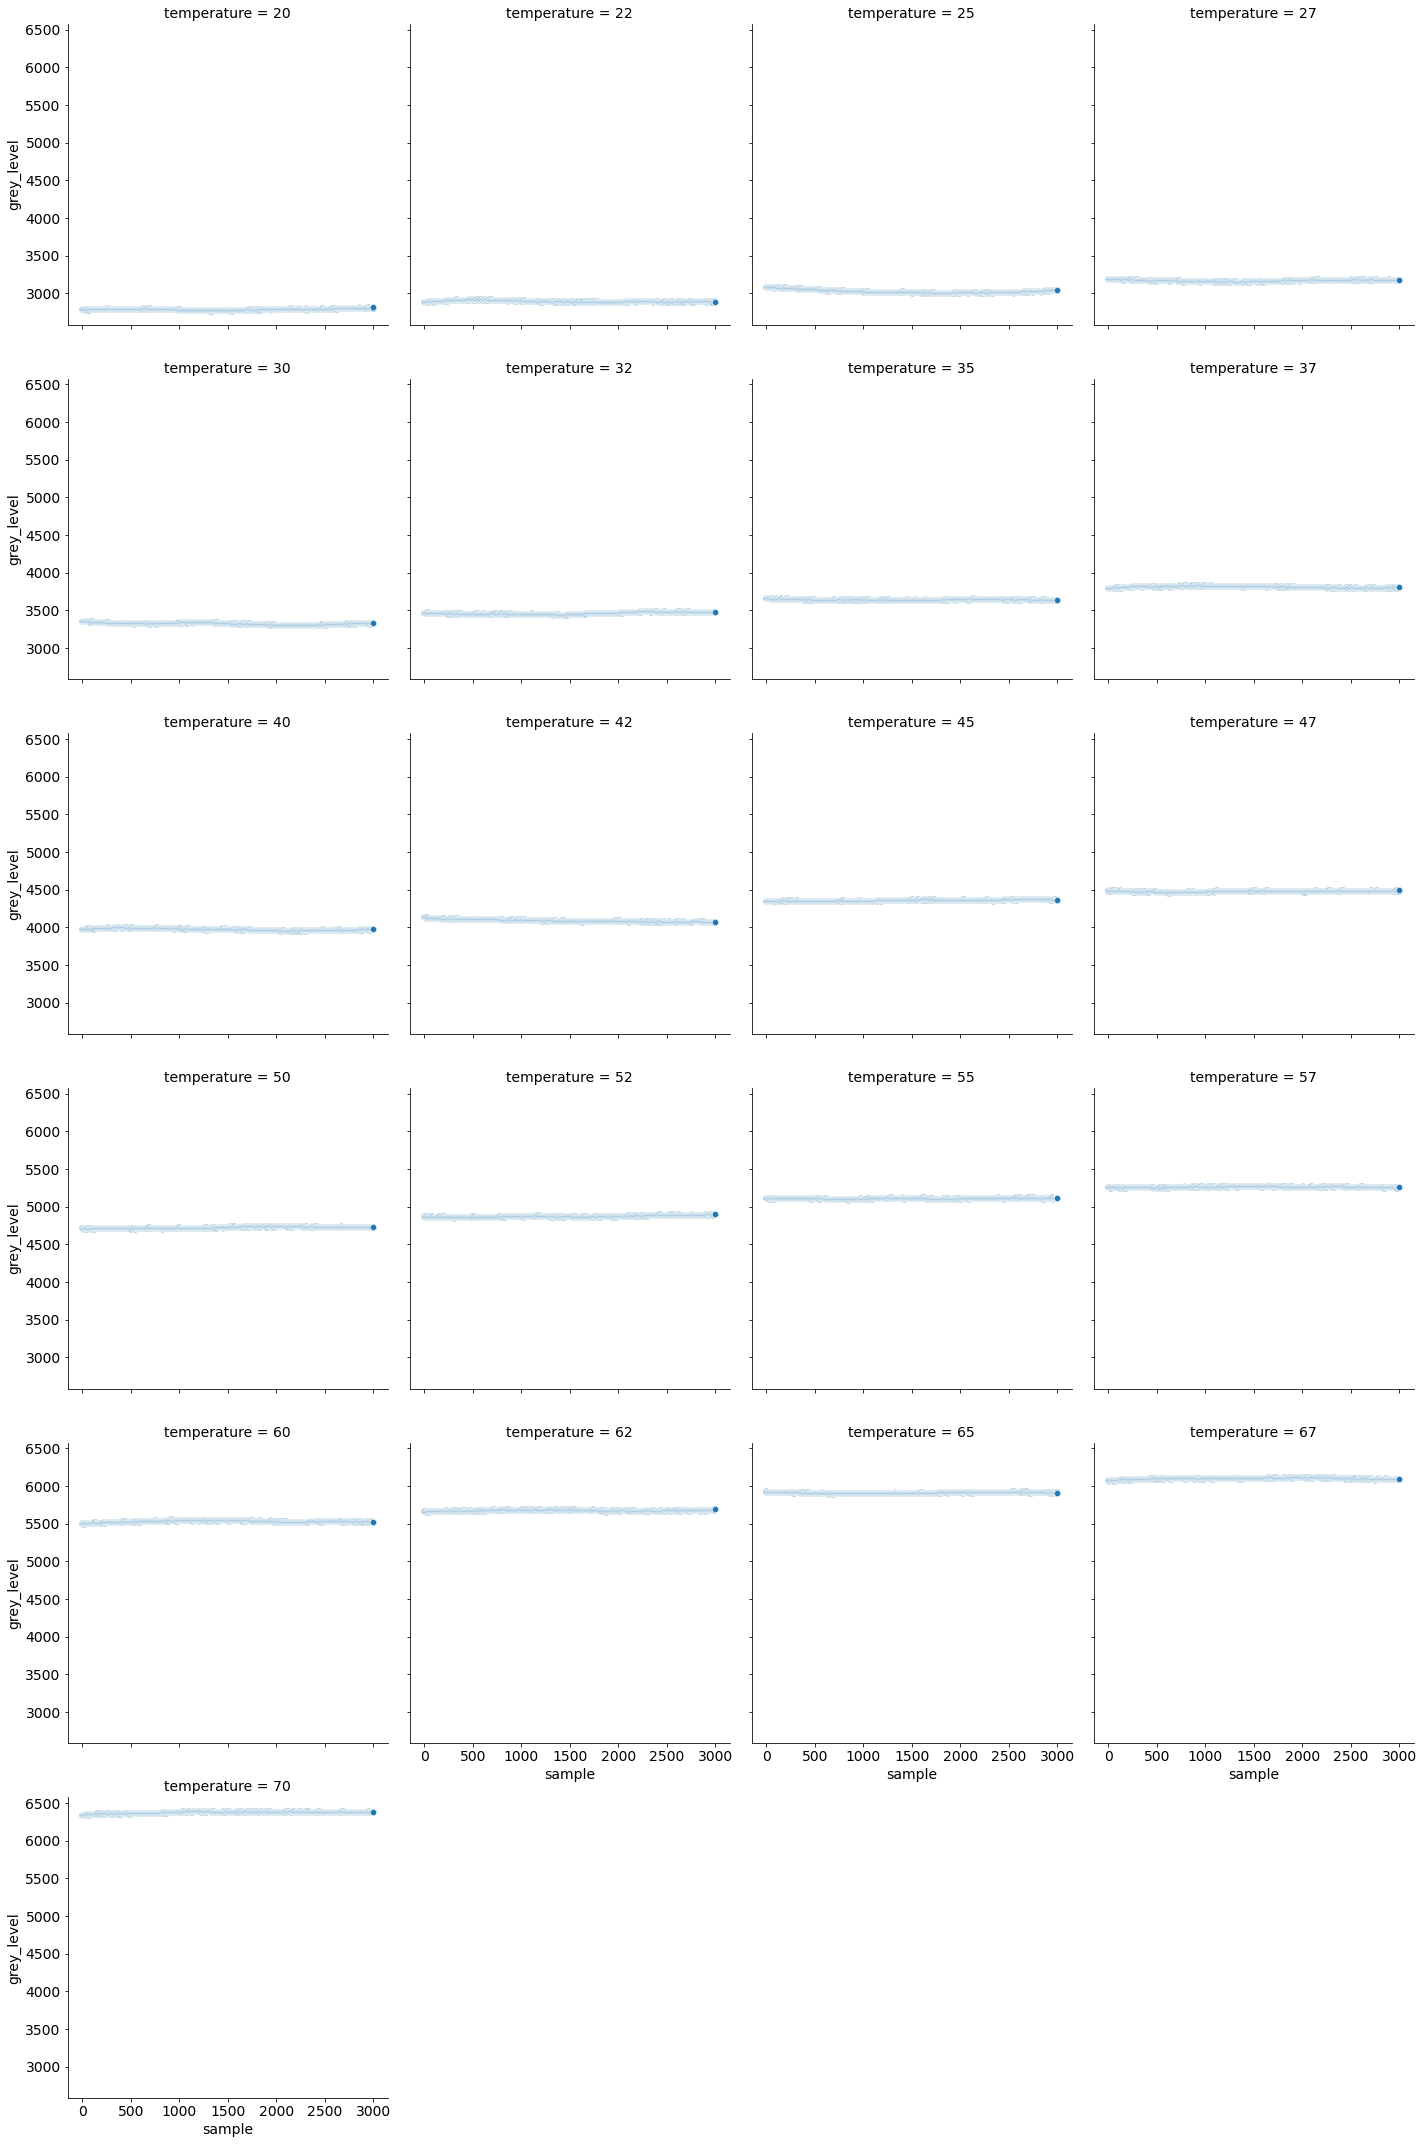

In [3]:
# Plot the change in intensity (grey-level) of a random pixel for a continuous frames acquisition:
def plotNoiseAnalysis(data):
    pix_over_frames_disp = data.melt(
        var_name="temperature", value_name="grey_level", ignore_index=False)
    pix_over_frames_disp.index.rename("sample", inplace=True)
    pix_over_frames_disp.reset_index(level=0, inplace=True)
    sns.relplot(x="sample", y="grey_level", data=pix_over_frames_disp,
                col="temperature", col_wrap=4)


pix_idx = np.random.randint(low=[0, 0], high=meas_panchromatic.shape[2:], size=2)
pix_over_frames = pd.DataFrame(meas_panchromatic[..., pix_idx[0], pix_idx[1]].T, 
                               columns=list_blackbody_temperatures)
plotNoiseAnalysis(pix_over_frames)
fig = plt.gcf()
fig.tight_layout()

Evident from the raw-data visualizations, there are 3 issues that come up:
1. The first frame of each temperature appears to be an outlier. infact, after some more careful verification, it seems that in some cases, all first 3 frames exhibit this phenomenon. To be on the safe side, it would be a good idea to discard them for the purpose of any further analysis.
2. The noise is highly correlated, as the trends in noise are smooth. This means that a gaussian noise assumption isn't valid. Nontheless, as trends are inconsistent at different temperatures (some are positive, some negative, and some oscillate and return to the same level) and since the trends' magnitudes aren't very significant, averaging frames might still be the best idea to eliminate the noise.
3. While not easily observable, some pixels in the upper-right corner are "burned", resulting in a salt-and-pepper like noise.

To tackle some of the issues, a pre-processing function was engineered, which chomps the 3 first frames, and filters the remaining frames with a 2x2 median filter.

In [4]:
from tools import prefilt_cam_meas
from plots import showFacetImages
meas_panchromatic_clean = prefilt_cam_meas(meas_panchromatic, first_valid_meas=0)
img_comp = np.stack((meas_panchromatic[0].mean(
    axis=0), meas_panchromatic_clean[0].mean(axis=0)))
showFacetImages(img_comp, "Phase", [
                "Before Pre-Processing", "After Pre-Processing"], facet_col_wrap=2,
                title="An Examplary Operating-Point Before and After Applying Pre-Processing")


Pre-Filtering Measurements: 100%|██████████| 21/21 [00:21<00:00,  1.01s/it]
